In [1]:
!pip install --quiet fairlearn shap

In [2]:
import pandas as pd
import numpy as np
import sklearn
import fairlearn
import shap

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import datetime as dt
import math

print(f"Import sucessful at {dt.datetime.now()}")

Import sucessful at 2025-08-11 01:30:09.045406


## Import data  

In [3]:
df = pd.read_csv("iris_combined.csv")
df.shape, df.columns, df.head()

((300, 7),
 Index(['flower_id', 'event_timestamp', 'species', 'sepal_length',
        'sepal_width', 'petal_length', 'petal_width'],
       dtype='object'),
    flower_id            event_timestamp    species  sepal_length  sepal_width  \
 0        110  2023-12-31 23:59:59+00:00  virginica           6.8          3.0   
 1        105  2023-12-31 23:59:59+00:00  virginica           6.7          3.3   
 2         20  2023-12-31 23:59:59+00:00     setosa           4.6          3.2   
 3        132  2023-12-31 23:59:59+00:00  virginica           6.9          3.1   
 4          1  2023-12-31 23:59:59+00:00     setosa           4.6          3.6   
 
    petal_length  petal_width  
 0           5.5          2.1  
 1           5.7          2.5  
 2           1.4          0.2  
 3           5.4          2.1  
 4           1.0          0.2  )

## Fairlearn  

- Introduce a “location” attribute in IRIS dataset with values 0 and 1 assigned randomly.       
- Incorporate fairlearn explainer with location as sensitive attribute.

### Prepare data for fairlearn  

In [4]:
# Add a column named 'location' and fill it with 1 and 0 randomly
df['location'] = np.random.randint(0, 2, df.shape[0])
df.shape, df.columns, df.head()

((300, 8),
 Index(['flower_id', 'event_timestamp', 'species', 'sepal_length',
        'sepal_width', 'petal_length', 'petal_width', 'location'],
       dtype='object'),
    flower_id            event_timestamp    species  sepal_length  sepal_width  \
 0        110  2023-12-31 23:59:59+00:00  virginica           6.8          3.0   
 1        105  2023-12-31 23:59:59+00:00  virginica           6.7          3.3   
 2         20  2023-12-31 23:59:59+00:00     setosa           4.6          3.2   
 3        132  2023-12-31 23:59:59+00:00  virginica           6.9          3.1   
 4          1  2023-12-31 23:59:59+00:00     setosa           4.6          3.6   
 
    petal_length  petal_width  location  
 0           5.5          2.1         1  
 1           5.7          2.5         1  
 2           1.4          0.2         1  
 3           5.4          2.1         0  
 4           1.0          0.2         1  )

In [5]:
df['location'].value_counts()

location
1    162
0    138
Name: count, dtype: int64

In [6]:
# Location value counts species wise
df.groupby('location')['species'].value_counts()

location  species   
0         virginica     50
          versicolor    48
          setosa        40
1         setosa        60
          versicolor    52
          virginica     50
Name: count, dtype: int64

In [7]:
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df['species']
X.shape, y.shape

((300, 4), (300,))

<Axes: xlabel='species'>

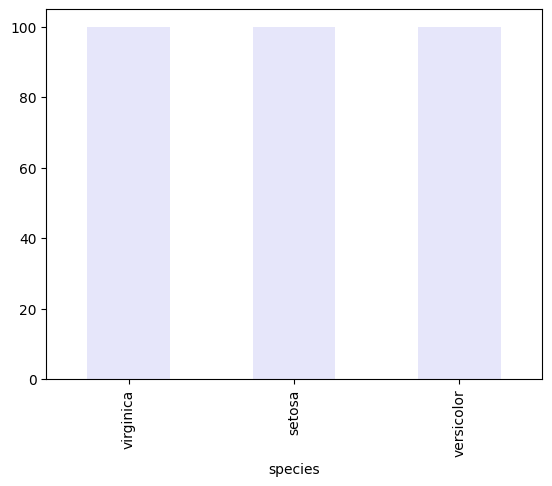

In [8]:
y.value_counts().plot.bar(color='lavender', 
                          # edgecolor='black'
                         )

### Evaluate fairness metrics

In [9]:
from fairlearn.metrics import MetricFrame, selection_rate, false_negative_rate
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [10]:
np.random.seed(42)

In [11]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, df['location'], test_size=0.4, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, A_train.shape, A_test.shape

((180, 4), (120, 4), (180,), (120,), (180,), (120,))

### Normalize features  

In [12]:
normalize = False

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

if normalize:
    # Standard scaling of train data
    X_train_scaled = scaler.fit_transform(X_train)

    X_train_scaled = pd.DataFrame(
        X_train_scaled, 
        columns=X_train.columns, 
        index=X_train.index
    )
    
    # Standard scaling of test data
    X_test_scaled = scaler.transform(X_test)

    X_test_scaled = pd.DataFrame(
        X_test_scaled,
        columns=X_test.columns,
        index=X_test.index
    )
    print("Scaling applied to features")
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    print("Scaling NOT applied")
    

print(X_train_scaled.shape, X_test_scaled.shape)
print()
print(X_train_scaled.head(), "\n\n", X_test_scaled.head())

Scaling NOT applied
(180, 4) (120, 4)

     sepal_length  sepal_width  petal_length  petal_width
55       5.700000     2.500000      5.000000     2.000000
172      5.045371     2.136361      3.488710     1.118773
184      6.572367     2.951919      5.845436     2.144146
167      6.710334     2.880494      4.801418     1.293013
139      7.600000     3.000000      6.600000     2.100000 

      sepal_length  sepal_width  petal_length  petal_width
203      6.025517     2.223579      5.055318     1.383327
266      5.732209     3.018632      4.134589     1.315357
152      6.287964     2.767592      4.646346     1.827343
9        5.000000     3.300000      1.400000     0.200000
233      4.880530     3.650848      1.485003     0.378946


In [14]:
# Train a decision tree model
# clf = DecisionTreeClassifier(min_samples_leaf=5, max_depth=2, random_state=42)
# clf = LogisticRegression(random_state=42)
clf = SVC(kernel='rbf', C=0.1, probability=True, random_state=42)

clf.fit(X_train_scaled, y_train)

SVC(C=0.1, probability=True, random_state=42)

In [15]:
class_probs = pd.DataFrame([clf.predict(X_test_scaled), clf.predict_proba(X_test_scaled)]).T
class_probs.shape, class_probs.head()

((120, 2),
             0                                                  1
 0  versicolor  [0.005011663263660334, 0.6384026472157887, 0.3...
 1  versicolor  [0.0067052929888838575, 0.9836628708329246, 0....
 2  versicolor  [0.006927941953379156, 0.5985583278756239, 0.3...
 3      setosa  [0.9796373256704171, 0.013761195389549279, 0.0...
 4      setosa  [0.978033822801678, 0.01482267489266605, 0.007...)

In [16]:
clf.predict(X_test_scaled)[:5]

array(['versicolor', 'versicolor', 'versicolor', 'setosa', 'setosa'],
      dtype=object)

In [17]:
y_pred = clf.predict(X_test_scaled)
print(y_pred[:5])
accuracy_score(y_test, y_pred)

['versicolor' 'versicolor' 'versicolor' 'setosa' 'setosa']


0.8583333333333333

In [18]:
mf = MetricFrame(metrics={
                            # "selection_rate": selection_rate, 
                            # "recall": recall_score,   # from sklearn
                            "accuracy": accuracy_score,
                            # "false negative": false_negative_rate,
                        },
                y_true=y_test,
                y_pred=y_pred,
                sensitive_features=A_test)
mf

In [19]:
mf.overall

accuracy    0.858333
dtype: float64

In [20]:
mf.by_group

,accuracy
location,
0,0.884615
1,0.838235


In [21]:
print("Difference:", round(mf.difference() * 100, 2))  # max in group - min in group 
print("Ratio:", round(mf.ratio(), 2))            # min / max

Difference: accuracy    4.64
dtype: float64
Ratio: accuracy    0.95
dtype: float64


In [22]:
print("Gap in pp:", round(mf.difference() * 100, 2))

Gap in pp: accuracy    4.64
dtype: float64


In [23]:
classes = clf.classes_
proba   = clf.predict_proba(X_test_scaled)

for c_idx, c in enumerate(classes):
    y_true_bin = (y_test == c).astype(int)
    y_pred_bin = (proba[:, c_idx] >= 0.5).astype(int)

    mf_c = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "recall": recall_score,   # from sklearn
            "false negative": false_negative_rate,
            "selection_rate": selection_rate, 
        },
        y_true=y_true_bin,
        y_pred=y_pred_bin,
        sensitive_features=A_test
    )

    print(f"\nClass: {c}")
    print(mf_c.by_group)
    
    print("Accuracy diff:", round(mf_c.difference()["accuracy"] * 100, 2))
    print("Recall diff:", round(mf_c.difference()["recall"] * 100, 2))
    print("False Negative diff:", round(mf_c.difference()["false negative"] * 100, 2))
    print("Selection rate diff:", round(mf_c.difference()["selection_rate"] * 100, 2))


Class: setosa
          accuracy  recall  false negative  selection_rate
location                                                  
0              1.0     1.0             0.0        0.250000
1              1.0     1.0             0.0        0.382353
Accuracy diff: 0.0
Recall diff: 0.0
False Negative diff: 0.0
Selection rate diff: 13.24

Class: versicolor
          accuracy    recall  false negative  selection_rate
location                                                    
0         0.865385  0.782609        0.217391        0.384615
1         0.941176  0.923077        0.076923        0.220588
Accuracy diff: 7.58
Recall diff: 14.05
False Negative diff: 14.05
Selection rate diff: 16.4

Class: virginica
          accuracy    recall  false negative  selection_rate
location                                                    
0         0.865385  0.875000        0.125000        0.365385
1         0.941176  0.896552        0.103448        0.397059
Accuracy diff: 7.58
Recall diff: 2.16
False 

## SHAP  

- Explain in simple words what do the SHAP full dataset explainer plots (similar to what was shown in the demo) for class virginica mean.

In [24]:
for i, cls in enumerate(clf.classes_):
    print(f"{cls}: {i}")

setosa: 0
versicolor: 1
virginica: 2


In [25]:
for i, feature in enumerate(clf.feature_names_in_):
    print(f"{feature}: {i}")

sepal_length: 0
sepal_width: 1
petal_length: 2
petal_width: 3


In [26]:
print(y_pred[:10])

['versicolor' 'versicolor' 'versicolor' 'setosa' 'setosa' 'versicolor'
 'setosa' 'virginica' 'virginica' 'setosa']


In [27]:
import shap

shap.initjs()
explainer = shap.KernelExplainer(clf.predict_proba, X_train_scaled)
shap_exp_object = explainer(X_test_scaled)
type(shap_exp_object)

Using 180 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/120 [00:00<?, ?it/s]

shap._explanation.Explanation

In [28]:
shap_exp_object

.values =
array([[[-7.65659222e-03, -1.89147174e-03,  9.54806396e-03],
        [-1.20873218e-02,  5.37185759e-02, -4.16312541e-02],
        [-2.97963645e-01,  1.83356090e-01,  1.14607554e-01],
        [-1.34469067e-02,  4.77584753e-02, -3.43115687e-02]],

       [[-5.28487512e-03,  3.04065387e-02, -2.51216636e-02],
        [-2.10176616e-03,  1.45529284e-03,  6.46473324e-04],
        [-3.09337102e-01,  5.27761331e-01, -2.18424229e-01],
        [-1.27370924e-02,  6.85787310e-02, -5.58416386e-02]],

       [[-1.09087663e-02, -3.43220671e-02,  4.52308334e-02],
        [-5.94635184e-03,  2.07694459e-02, -1.48230941e-02],
        [-2.89821651e-01,  3.15432799e-01, -2.56111475e-02],
        [-2.25614174e-02, -5.87828269e-02,  8.13442443e-02]],

       ...,

       [[-1.50578382e-02, -2.96493782e-02,  4.47072163e-02],
        [-6.29725430e-05, -4.70365950e-03,  4.76663204e-03],
        [-2.80557927e-01, -2.13307436e-01,  4.93865363e-01],
        [-3.52523503e-02, -1.06393358e-01,  1.41645708e-

In [29]:
# shap_values = explainer.shap_values(X_test_scaled)
shap_values = shap_exp_object.values
type(shap_values)

numpy.ndarray

In [30]:
shap_values.shape, shap_values

((120, 4, 3),
 array([[[-7.65659222e-03, -1.89147174e-03,  9.54806396e-03],
         [-1.20873218e-02,  5.37185759e-02, -4.16312541e-02],
         [-2.97963645e-01,  1.83356090e-01,  1.14607554e-01],
         [-1.34469067e-02,  4.77584753e-02, -3.43115687e-02]],
 
        [[-5.28487512e-03,  3.04065387e-02, -2.51216636e-02],
         [-2.10176616e-03,  1.45529284e-03,  6.46473324e-04],
         [-3.09337102e-01,  5.27761331e-01, -2.18424229e-01],
         [-1.27370924e-02,  6.85787310e-02, -5.58416386e-02]],
 
        [[-1.09087663e-02, -3.43220671e-02,  4.52308334e-02],
         [-5.94635184e-03,  2.07694459e-02, -1.48230941e-02],
         [-2.89821651e-01,  3.15432799e-01, -2.56111475e-02],
         [-2.25614174e-02, -5.87828269e-02,  8.13442443e-02]],
 
        ...,
 
        [[-1.50578382e-02, -2.96493782e-02,  4.47072163e-02],
         [-6.29725430e-05, -4.70365950e-03,  4.76663204e-03],
         [-2.80557927e-01, -2.13307436e-01,  4.93865363e-01],
         [-3.52523503e-02, -1.06

In [31]:
# Check if sum of SHAP values is zero

tolerance = 1e-10 # Define your acceptable tolerance for "almost zero"

shap_val = sum(shap_values[0][0])

if math.isclose(shap_val, 0, abs_tol=tolerance):
    print(f"{shap_val} is almost zero.")
else:
    print(f"{shap_val} is not almost zero.")

-1.1796119636642288e-16 is almost zero.


### Visualize SHAP results step by step  

In [32]:
type(shap_values), shap_values.shape

(numpy.ndarray, (120, 4, 3))

setosa


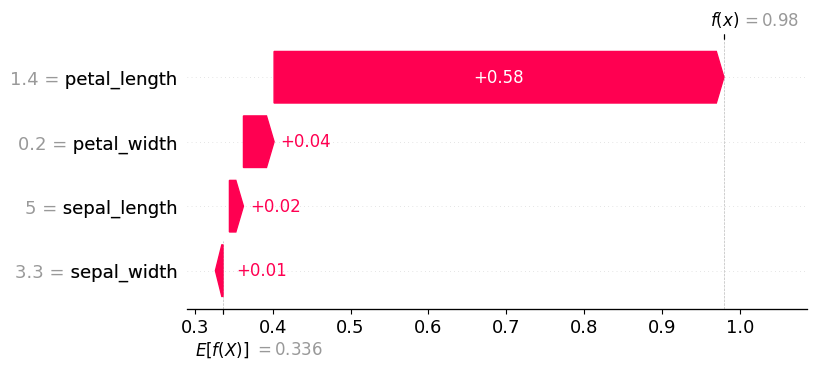

In [33]:
# visualize the first prediction's explanation (Setosa)
print(y_pred[3])
shap.plots.waterfall(shap_exp_object[3][:, 0])

In [34]:
# visualize the first prediction's explanation with a force plot
print(y_pred[3])
shap.plots.force(shap_exp_object[3][:, 0])

setosa


versicolor


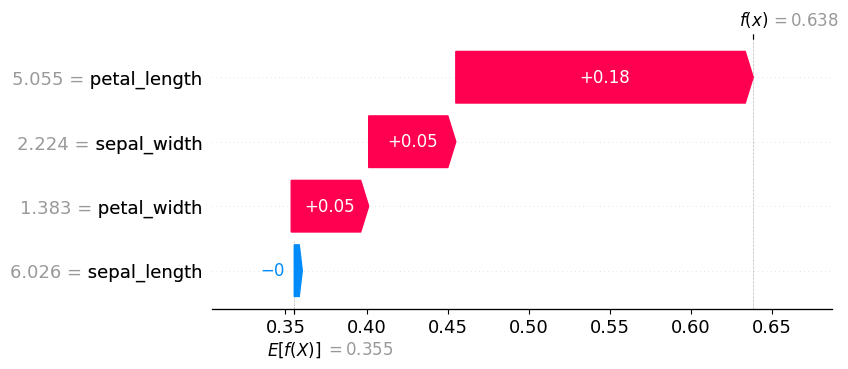

In [35]:
# visualize the first prediction's explanation (Versicolor)
print(y_pred[0])
shap.plots.waterfall(shap_exp_object[0][:, 1])

In [36]:
# visualize the first prediction's explanation with a force plot
print(y_pred[0])
shap.plots.force(shap_exp_object[0][:, 1])

versicolor


virginica


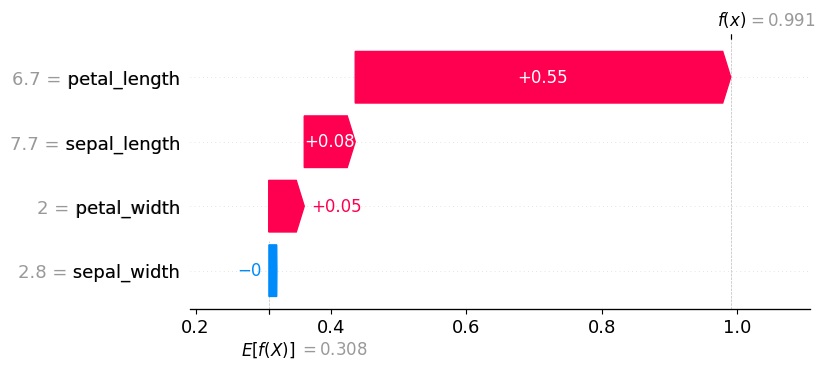

In [37]:
# visualize the first prediction's explanation (Virginica)
print(y_pred[7])
shap.plots.waterfall(shap_exp_object[7][:, 2])

In [38]:
# visualize the first prediction's explanation with a force plot
print(y_pred[7])
shap.plots.force(shap_exp_object[7][:, 2])

virginica


In [39]:
# Shap plot for class 0 (setosa)

shap.plots.force(shap_exp_object.base_values[0][0], shap_values[..., 0], X_test_scaled)

In [40]:
# Shap plot for class 1 (versicolor)
shap.force_plot(shap_exp_object.base_values[0][1], shap_values[..., 1], X_test_scaled)

In [41]:
# Shap plot for class 2 (virginica)
shap.force_plot(shap_exp_object.base_values[0][2], shap_values[..., 2], X_test_scaled)

## Unnormalized data distributions

In [42]:
df.groupby('species')["petal_length"].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,100.0,1.468921,0.204052,0.948662,1.370161,1.500000,1.598849,2.049254
versicolor,100.0,4.287989,0.476124,3.000000,4.000000,4.390259,4.600622,5.219676
virginica,100.0,5.470172,0.520550,4.500000,5.090876,5.450000,5.781243,6.900000


<Axes: xlabel='species', ylabel='petal_length'>

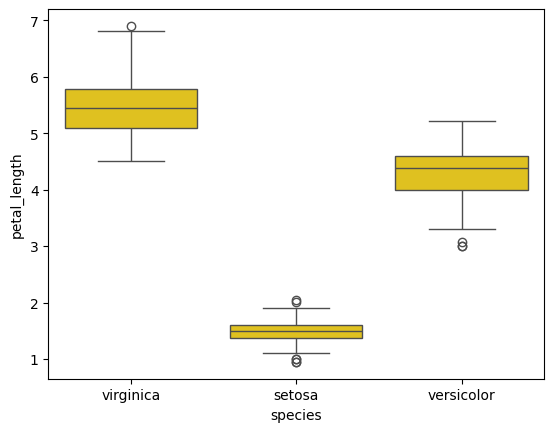

In [43]:
sns.boxplot(x='species', y = "petal_length", data = df, color='gold')

In [44]:
df.groupby('species')["petal_width"].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,100.0,0.236097,0.115856,-0.014867,0.2,0.200000,0.301338,0.629743
versicolor,100.0,1.339638,0.211853,0.886278,1.2,1.394958,1.500000,1.813152
virginica,100.0,2.054864,0.290760,1.383327,1.8,2.024067,2.300000,2.601080


<Axes: xlabel='species', ylabel='petal_width'>

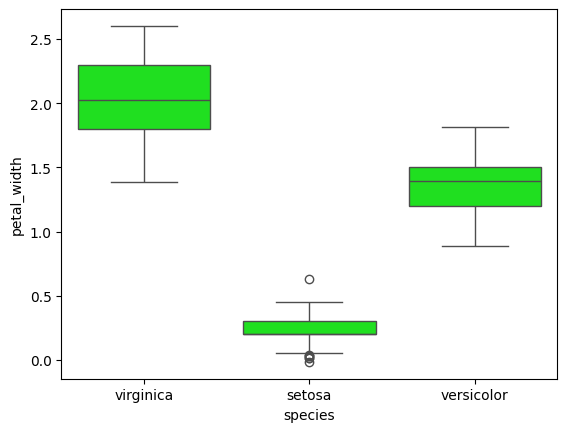

In [45]:
sns.boxplot(x='species', y = "petal_width", data = df, color='lime')

In [46]:
df.groupby('species')["sepal_length"].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,100.0,4.982680,0.364020,4.209508,4.700000,5.000000,5.200000,5.820143
versicolor,100.0,5.935499,0.541866,4.815756,5.595743,5.877607,6.327583,7.195814
virginica,100.0,6.480472,0.559466,4.900000,6.177357,6.399976,6.709098,7.900000


<Axes: xlabel='species', ylabel='sepal_length'>

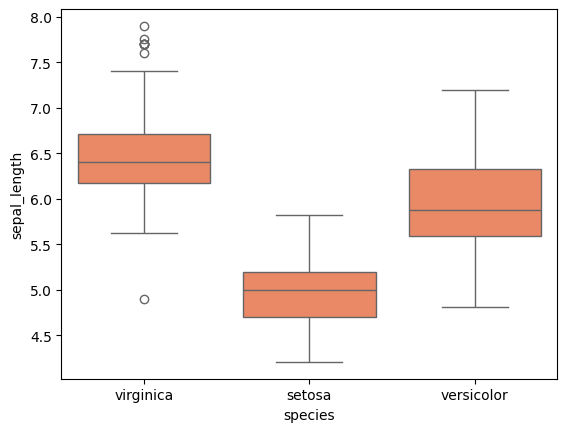

In [47]:
sns.boxplot(x='species', y = "sepal_length", data = df, color='coral')

In [48]:
df.groupby('species')["sepal_width"].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,100.0,3.383523,0.366964,2.282185,3.122681,3.400000,3.600000,4.4
versicolor,100.0,2.771412,0.329300,1.968631,2.500000,2.800000,3.000000,3.4
virginica,100.0,2.956518,0.312751,2.200000,2.798847,2.989732,3.141118,3.8


<Axes: xlabel='species', ylabel='sepal_width'>

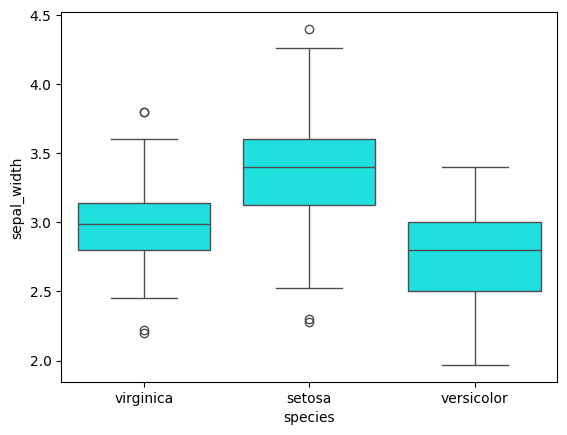

In [49]:
sns.boxplot(x='species', y = "sepal_width", data = df, color='aqua')

### One plot to show them all!

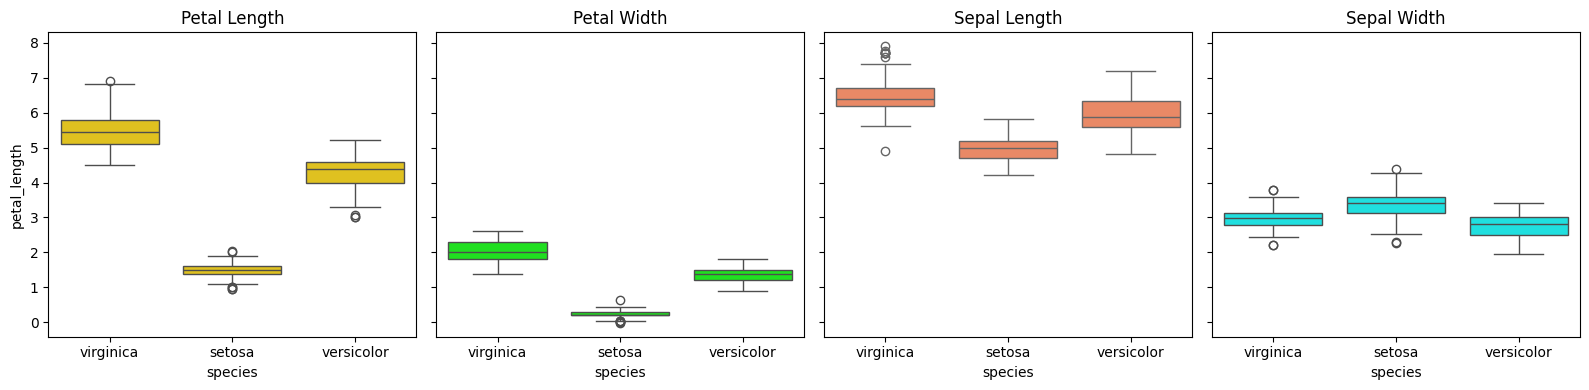

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

sns.boxplot(ax=axes[0], x='species', y="petal_length", data=df, color='gold')
axes[0].set_title("Petal Length")

sns.boxplot(ax=axes[1], x='species', y="petal_width", data=df, color='lime')
axes[1].set_title("Petal Width")

sns.boxplot(ax=axes[2], x='species', y="sepal_length", data=df, color='coral')
axes[2].set_title("Sepal Length")

sns.boxplot(ax=axes[3], x='species', y="sepal_width", data=df, color='aqua')
axes[3].set_title("Sepal Width")

plt.tight_layout()
plt.show()